In [16]:
import os
import pandas as pd
from PIL import Image
import numpy as np
#import matplotlib as mpl
import cv2  # conda install -c conda-forge opencv
from moviepy.editor import VideoFileClip
from moviepy.editor import *


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
#plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15

In [17]:
vid_path = "./data/videos/individual-rotifer/"
vid_filename = "2024_0216_161747_055.MP4"  # d_high
vid_filepath = f"{vid_path}{vid_filename}"
PROCESS_VIDEO = False
SAVE_VIDEO = False
SHOW_VIDEO = False
SHOW_FRAME = False
print(vid_filepath)

trim_start = 25 #70 for 54, 25 for 55, 0 for 64
trim_end = 45 # 80 for 54, 45 for 55, 5 for 64
trim_duration = trim_end - trim_start

if PROCESS_VIDEO:
    video_clip = VideoFileClip(vid_filepath).subclip(trim_start, trim_end)
    duration = video_clip.duration
    resolution = video_clip.size
    fps = video_clip.fps

    print(duration, fps, resolution)
    if SAVE_VIDEO:
        video_clip.write_videofile(f"{vid_path}{vid_filename.split('.')[0]}_{trim_duration}sec.mp4",
                                    fps=fps, codec="libx264", audio=False)
    video_clip.close()

./data/videos/individual-rotifer/2024_0216_161747_055.MP4


In [18]:
if SHOW_VIDEO:
    vid_filepath_trim = f"{vid_path}{vid_filename.split('.')[0]}_{trim_duration}sec.mp4"
    video_clip = VideoFileClip(vid_filepath_trim)
    video_clip.ipython_display(t=5) # no interactive mode
    #video_clip.show(5, interactive=True)  # use this for interactive, easy cropping area

In [19]:
if SHOW_FRAME:
    vid_filepath_trim = f"{vid_path}{vid_filename.split('.')[0]}_{trim_duration}sec.mp4"
    cap = cv2.VideoCapture(vid_filepath_trim)
    ret, frame = cap.read()
    height, width, _ = frame.shape
    print(height, width)

    plt.figure()
    plt.imshow(frame)
    #plt.imshow(frame[100:900, 1100:1500])

In [20]:
if SAVE_VIDEO:
    # video_crop = video_clip.fx(vfx.crop, x1=1250, x2=2100, y1=250, y2=2100) # for 55
    # video_crop = video_clip.fx(vfx.crop, x1=0, x2=700, y1=0, y2=height) fpr 54
    video_crop = video_clip.fx(vfx.crop, x1=1100, x2=1500, y1=100, y2=900) # fpr 64
    #video_crop = video_crop.rotate(90)
    #video_crop = vfx.mirror_x(video_crop) # .fx(vfx.rotate(90))
    video_crop.write_videofile(f"{vid_path}{vid_filename.split('.')[0]}_{trim_duration}sec_cropped.mp4", fps=fps, codec="libx264", audio=False)
    video_crop.close()

# Analysis

In [21]:
vid_path = "./data/videos/individual-rotifer/"
vid_filename = f"2024_0216_161747_055_{trim_duration}sec_cropped"
vid_extension = ".mp4"

vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"
seg_mask_path = f"./data/results/{vid_filename}_masks"

vid_clip = VideoFileClip(vid_filepath)
fps = int(vid_clip.fps)  # get from file original, not segmented
resolution = vid_clip.size
vid_clip.close()

print(fps, resolution)

24 [1850, 850]


## Frame extraction

In [22]:
EXTRACT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5  # correspond to seg-masks

if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True)
    video = cv2.VideoCapture(vid_filepath)
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()

In [23]:
# Construct output figure path
save_figure_path = "_".join(seg_mask_path.split("_")[:-1])
os.makedirs(save_figure_path, exist_ok=True)
save_figure_path = os.path.join(save_figure_path, vid_filename)

### Get Segmentation Mask and video properties

In [24]:
# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Construct the dataframe
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

num_frames = len(df)
print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)

# Adjust resolution depending on frame rate
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Load in the segmentation masks and find contrours
from utils import get_contours_from_segmasks, get_contour_stats
segmentation_mask_filepaths = df["mask_fpath"].tolist()
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths)

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
df.head(5)

num_frames: 480 ; save_figure_path: ./data/results/2024_0216_161747_055_20sec_cropped/2024_0216_161747_055_20sec_cropped ; fps: 24 ; resolution: [1850, 850]
UHD, pixel_per_real_width =  0.4


,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
0,0,0.000000,./data/results/2024_0216_161747_055_20sec_crop...,211,269,46973.5,148282,0.316785,1287.834690,0.615071,31.343748,NaN,./data/images/2024_0216_161747_055_20sec_cropp...,1
1,1,0.041754,./data/results/2024_0216_161747_055_20sec_crop...,214,272,47964.0,150600,0.318486,1286.018458,0.597610,30.877409,4.242641,./data/images/2024_0216_161747_055_20sec_cropp...,0
2,2,0.083507,./data/results/2024_0216_161747_055_20sec_crop...,215,277,48757.5,154432,0.315721,1303.089525,0.598425,30.429125,5.099020,./data/images/2024_0216_161747_055_20sec_cropp...,0
3,3,0.125261,./data/results/2024_0216_161747_055_20sec_crop...,218,283,48871.5,155400,0.314488,1317.089523,0.579151,29.615461,6.708204,./data/images/2024_0216_161747_055_20sec_cropp...,0
4,4,0.167015,./data/results/2024_0216_161747_055_20sec_crop...,219,286,49092.0,157863,0.310979,1322.989018,0.581574,29.402349,3.162278,./data/images/2024_0216_161747_055_20sec_cropp...,0


In [25]:
700

700

### Find interesting frames to highlight or use arbitrary frames

In [26]:
print(df.area.idxmax(), df.area.idxmin())

138 301


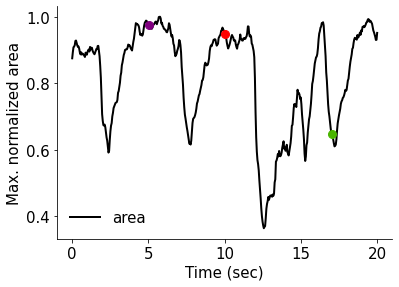

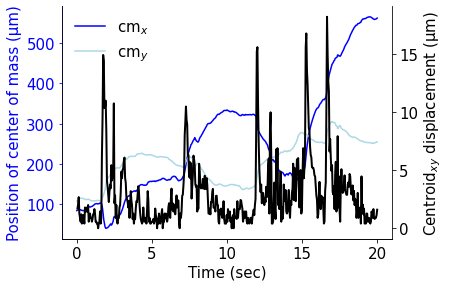

In [27]:
SAVE_FIGURES = True
plt.rcParams["font.size"] = 15

# Select sub_frames for highlighting
highlight_frames = [120, 240, 408]  # only considers the frames shown as subsample
cmcolors = [colors[hl] for hl in highlight_frames]

# Figures Rotifer body shape outline area
plt.figure(figsize=(5.8,4.25))
plt.plot(df["time"], df["area"] / df["area"].max(), "-k", lw=2, label="area")
for cframe, cm_hl in zip(highlight_frames, cmcolors):
    plt.plot(df.loc[cframe, "time"], df.loc[cframe, "area"] / df["area"].max(), "o", color=cm_hl, ms=8)

plt.xlabel("Time (sec)"); plt.ylabel("Max. normalized area");
plt.legend(frameon=False)
plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-area.jpg", dpi=300)

# Figure Double YAxis Rotifer center of mass and displacement
plt.figure(figsize=(6.5,4.25))
ax1 = plt.gca()
ax1.plot(df["time"], df["centroid_x"] * pixel_per_real_width, "-", color="blue", lw=1.5, label="cm$_x$")
ax1.plot(df["time"], df["centroid_y"] * pixel_per_real_width, "-", color="lightblue", lw=1.5, label="cm$_y$")
ax1.set_ylabel("Position of center of mass (µm)"); ax1.set_xlabel("Time (sec)"); 
ax1.spines["left"].set_color("blue")
ax1.yaxis.label.set_color("blue")
ax1.tick_params(axis="y", color="blue")
ax1.set_yticklabels(labels=[int(x) for x in ax1.get_yticks()], color="blue")

ax2 = plt.twinx()
ax2.plot(df["time"], df["centroid_dist"] * pixel_per_real_width, "-k", lw=2)
ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color("black")

ax2.set_xlabel("Time (sec)"); ax2.set_ylabel("Centroid$_x$$_y$ displacement (µm)");
ax1.legend(frameon=False)
plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-centroids.jpg", dpi=300)

## Plot raw images and overlay mask contour
- maybe do this at the beggining!!! after looking at what frames / times are intersting

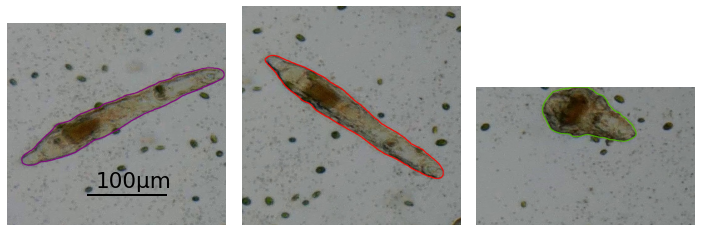

In [28]:
SAVE_FIGURES = True

desired_scale_width = 100  # in mu
scaled_width = desired_scale_width / (pixel_per_real_width)
contour_lw = 2  # contor line width

fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=len(highlight_frames), layout="constrained")
longest = 700 # 800 pixels is longest extension
# ± extention > make it more felxible with different xneg, xpos, yneg, ypos values
scalebar_posxy = [300, 300]

for nth, cframe in enumerate(highlight_frames):
    
    # Centering frame on Centroid
    x, y = df.loc[cframe, "centroid_x"], df.loc[cframe, "centroid_y"]
    xlow, xhigh = x - (longest / 2), x + (longest / 2)
    ylow, yhigh = y - (longest / 2), y + (longest / 2)
    
    # Image and contour coloring
    cimg = cv2.imread(df.loc[cframe, "img_fpath"], 1)
    cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)
    cnt = contour_list[cframe]  # contour
    ccolors = tuple([c * 255 for c in colors[cframe]])
    
    # Draw contour on image
    cv2.drawContours(cimg, [cnt], 0, ccolors, contour_lw)
    ax[nth].imshow(cimg)

    # Axis
    ax[nth].invert_yaxis()
    ax[nth].set_ylim([ylow, yhigh]); ax[nth].set_xlim([xlow, xhigh])
    ax[nth].set_axis_off()

# Scalebar
ax[0].plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
ax[0].text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] + 25, f"{desired_scale_width}µm", size="x-large")
plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-Individual-frames-highlighted_{highlight_frames}.jpg", dpi=300)

## Segmentation Mask plots over time

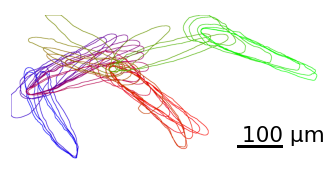

In [29]:
SAVE_FIGURES = True # Scale bar > can be moved somewhere else or config for defaults

scalebar_posxy = [1300, 100]  # automate or set axis tight and then have a 0-100 scale with corresponding ticks
cxlim = [-20, 1800]
cylim = [0, 900]

# Prep subsampled data
sub_maskpaths = df["mask_fpath"].tolist()[::every_nth_frame]
#sub_imgpaths = df["img_fpath"].tolist()[::every_nth_frame]
sub_contours = contour_list[::every_nth_frame]

# Background white
first_frame = cv2.imread(sub_maskpaths[0])
background = np.ones_like(first_frame) * 255

# Get subsampled contours
for nth, cnt in enumerate(sub_contours):
    ccolors = sub_colors[nth]
    ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
    cv2.drawContours(background, [cnt], 0, (ccolors[0], ccolors[1], ccolors[2]), 2)

# Figure - Draw contours
plt.figure(figsize=(5,5), layout="constrained")
plt.imshow(background)
plt.xlim(cxlim); plt.ylim(cylim);
plt.axis("off")

# Scalebar
plt.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=3)
plt.text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] + 25, f"{desired_scale_width} µm", size="x-large")
plt.tight_layout() # can also set limits in next cell or give back the ax handle?!

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-fps_{fps}-subsampled_{every_nth_frame}.jpg", dpi=300)

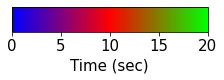

In [30]:
import matplotlib as mpl
fig = plt.figure(figsize=(3, 1), layout='constrained')
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=int(df["time"].max())), cmap=mpl.cm.brg),
             cax=fig.gca(), orientation='horizontal', label='Time (sec)')
if SAVE_FIGURES: fig.savefig(f"{save_figure_path}-colorbar.jpg", dpi=300)